In [ ]:
#TODO remove
interesting code:
#: https://github.com/reeanne/FinalProject/blob/cef6b45060ad9646f2be4de93c226aebeadec41b/essentia-master/src/examples/python/streaming_extractor/tonaldescriptors.py
#https://github.com/LqNoob/Essentia/blob/7a70a25dd6668855b3677bd0cae0df190e319cbf/test/src/unittest/tonal/test_chordsdetection_streaming.py
#∫imple one https://github.com/mariogearth/ChordsDetectionPython/blob/b69e813bef92a361e7cad0a58bbd0f049b252914/old%20stuff/chords_test3.py

In [ ]:
#check student notebook later for loadChromaAndSpectrum 

In [33]:
import sys, os
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

import essentia, essentia.standard, essentia.streaming
import essentia.standard as ess
from essentia.streaming import *

In [18]:
def computeChords(filename, frameSize=4096, hopSize=2048, tuningFrequency=440.0):

    #TODO:check pools https://essentia.upf.edu/documentation/essentia_python_tutorial.html 

    pool = essentia.Pool()
    loader = essentia.streaming.MonoLoader(filename=filename)
    
    #get the frames and compute chord detection
    fc = FrameCutter(frameSize=frameSize,
                     hopSize=hopSize,
                     silentFrames='noise')

    w = Windowing(type='blackmanharris62')
    spec = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                      magnitudeThreshold=1e-05,
                                      minFrequency=40,
                                      maxFrequency=5000,
                                      maxPeaks=10000)
    
    #TODO learn: https://essentia.upf.edu/documentation/reference/std_HPCP.html
    hpcp = HPCP(
        size=12,
        referenceFrequency = tuningFrequency,
        harmonics = 8,
        bandPreset = True,
        minFrequency = 40.0,
        maxFrequency = 5000.0,
        bandSplitFrequency = 250.0,
        weightType = "cosine",
        nonLinear = False,
        windowSize = 1.0,
        normalized='unitSum')
    
    #TODO: check parameters https://essentia.upf.edu/documentation/reference/std_ChordsDetection.html
    chords = ChordsDetection()
    chords_desc = ChordsDescriptors()


    # connect algorithms together
    loader.audio >> fc.signal
    fc.frame >> w.frame >> spec.frame
    spec.spectrum >> spectralpeaks.spectrum
    spec.spectrum >> (pool, 'spectrum.magnitude') #mine
    spectralpeaks.frequencies >> hpcp.frequencies
    spectralpeaks.magnitudes >> hpcp.magnitudes
    hpcp.hpcp >> (pool, 'chroma.hpcp')  #mine
    hpcp.hpcp >> chords.pcp
    chords.chords >> (pool, 'chords.chords')
    chords.strength >> (pool, 'chords.strength')

    essentia.run(loader)

    
    spectrum= pool['spectrum.magnitude']
    chroma= pool['chroma.hpcp']
    chords= pool['chords.chords']
    chords_strength= pool['chords.strength']
    
    return spectrum, chroma, chords, chords_strength

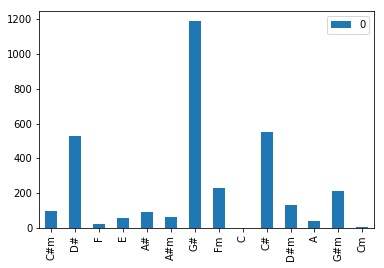

In [41]:
#test
testAudio = './test-audio/Disc 1 - 01 - Maple Leaf Rag.flac'
(test, test2, chords, test4) =computeChords(testAudio)

#chord histogram
chord_counts = Counter(chords)
df = pd.DataFrame.from_dict(chord_counts, orient='index')
df.plot(kind='bar')